In [1]:
from manim import *
import math
import jupyter_capture_output

video_scene = " -v WARNING --disable_caching dt_Scene"
image_scene = f" -v WARNING --disable_caching -r {2*427},{2*240}  -s dt_Scene"

Jupyter Capture Output v0.0.11


In [2]:
# global image colors
COLOR_TIMS = GRAY
COLOR_DEFLECTION_PLATE = DARK_GRAY
COLOR_ESI_CAPILLARY_EXIT = GRAY


# global font
latex_font = "Latin Modern Roman"


# trap function
def get_trap_funct(strength):
    def trap_funct(x):
        return 2*strength * np.exp(-((x-1.25)*2)**2) - 0.5
    return trap_funct

def get_trap_funct_hard(strength):
    def trap_funct(x):
        if x < 2:
            return strength
        else:
           return strength - 2*(strength+0.5)*(x-2)
    return trap_funct


# accumulate function
def get_accumulate_funct(strength):
    def accumulate_funct(x):
        if (x <= 9):
            return strength * (1 + math.erf((x-6)/1.5)) - 0.5
        else:
            return (accumulate_funct(9)-0.01) * np.exp(-((x-9)*3)**2)
    return accumulate_funct

def get_accumulate_funct_hard(strength):
    def accumulate_funct(x):
        if (x <= 4):
            return -0.5
        elif (x <= 4.25):
            return 2 * (x-4.25)
        elif (x <= 8.25):
            return (strength)/4 * (x-4.5)
        elif (x <= 9):
            return strength
        elif (x <= 9.5):
            return strength - 2*(strength * (x-9))
        else:
            return 0
    return accumulate_funct

In [109]:
# particle positions


# +++ before entering tube +++
pre_trap_big = np.array([
    [-8, 0.5],
    [-5.2, 0.85],
    [-4.25, -0.9]
])

pre_trap_medium = np.array([
    [-6, 1.1],
    [-4.85, -0.25],
    [-3, 0.3]
])

pre_trap_small = np.array([
    [-6.7, 0.13],
    [-3.7, +0.46],
    [-5.9, -0.7]
])


# +++ trapping +++
trap_big = np.array([
    [0.6, 0.4],
    [0.8, 0],
    [0.6, -0.4]
])

trap_medium = np.array([
    [0.4, -0.1],
    [0.95, -0.35],
    [0.45, 0.17]
])

trap_small = np.array([
    [0.6, -0.2],
    [0.3, 0.45],
    [0.9, 0.3]
])


# +++ accumulation +++
accumulation_big = np.array([
    [7.5, 0.5],
    [7.8, 0.1],
    [7.7, -0.3]
])

accumulation_medium = np.array([
    [6.66, 0.04],
    [6.55, -0.15],
    [6.5, 0.2]
])

accumulation_small = np.array([
    [5.4, 0.03],
    [5.5, 0.16],
    [5.45, -0.2]
])


# calculates the transition position for a t in [0, 1] and starting, end position
def get_transition_position(start_pos, end_pos, t):
    t_fluid = t
    return (1-t_fluid)*start_pos + t_fluid*end_pos

In [102]:
class DriftTube(Mobject):
    def __init__(self, center = np.array([0, 0, 0]), height = 1.5, width = 5, tunnel_line_width = 4, **kwargs):
        super().__init__(**kwargs)
        self.center = center
        self.tims_height = height
        self.tims_width = width

        # define main drift tube coordinates
        self.up_left = self.center + self.tims_height/2*UP + self.tims_width/2*LEFT + self.tims_width/2*LEFT + self.tims_height/2*UP
        self.up_mid = self.center + self.tims_height/2*UP + self.tims_width/2*LEFT
        self.up_right = self.center + self.tims_height/2*UP + self.tims_width/2*RIGHT

        self.down_left = self.center + self.tims_height/2*DOWN + self.tims_width/2*LEFT + self.tims_width/2*LEFT + self.tims_height/2*DOWN
        self.down_mid = self.center + self.tims_height/2*DOWN + self.tims_width/2*LEFT
        self.down_right = self.center + self.tims_height/2*DOWN + self.tims_width/2*RIGHT
        

        # drift tube main lines
        tims_tunnel_up = Line(start = self.up_mid, end = self.up_right, stroke_color = COLOR_TIMS, stroke_width = tunnel_line_width)
        tims_tunnel_down = Line(start = self.down_mid, end = self.down_right, stroke_color = COLOR_TIMS, stroke_width = tunnel_line_width)
        ion_funnel_up = Line(start = self.up_left, end = self.up_mid, stroke_color = COLOR_TIMS, stroke_width = tunnel_line_width)
        ion_funnel_down = Line(start = self.down_left, end = self.down_mid, stroke_color = COLOR_TIMS, stroke_width = tunnel_line_width)
        self.add(tims_tunnel_up, tims_tunnel_down, ion_funnel_up, ion_funnel_down)

        # drift tube seperators
        sep_up_left = Line(start = self.up_left, end = self.up_left + self.tims_height/3*UP, stroke_color = COLOR_TIMS, stroke_width = tunnel_line_width)
        sep_up_mid = Line(start = self.up_mid, end = self.up_mid + self.tims_height/3*UP, stroke_color = COLOR_TIMS, stroke_width = tunnel_line_width)
        sep_up_right =  Line(start = self.up_right, end = self.up_right + self.tims_height/3*UP, stroke_color = COLOR_TIMS, stroke_width = tunnel_line_width)

        sep_down_left = Line(start = self.down_left, end = self.down_left + self.tims_height/3*DOWN, stroke_color = COLOR_TIMS, stroke_width = tunnel_line_width)
        sep_down_mid = Line(start = self.down_mid, end = self.down_mid + self.tims_height/3*DOWN, stroke_color = COLOR_TIMS, stroke_width = tunnel_line_width)
        sep_down_right = Line(start = self.down_right, end = self.down_right + self.tims_height/3*DOWN, stroke_color = COLOR_TIMS, stroke_width = tunnel_line_width)
        self.add(sep_up_left, sep_up_mid, sep_up_right, sep_down_left, sep_down_mid, sep_down_right)


        # descriptors
        ion_funnel_descriptor = Text("Ion Funnel", color = BLACK, font_size = 24).next_to(ion_funnel_up, UP)
        tims_tunnel_descriptor = Text("TIMS Tunnel", color = BLACK, font_size = 24).next_to(tims_tunnel_up, UP).shift(0.75*UP)
        exit_funnel_descriptor = Text("Exit Funnel", color = BLACK, font_size = 24).next_to(ion_funnel_up, UP).shift(8/5*self.tims_width*RIGHT)
        self.add(ion_funnel_descriptor, tims_tunnel_descriptor, exit_funnel_descriptor)


        # coordinate system for tube
        x_tube_length = self.tims_width
        y_tube_length = self.tims_height 
        self.tube_ax = NumberPlane(x_range = [0, 10], y_range = [-1, 1], x_length = x_tube_length, y_length = y_tube_length,
            x_axis_config = {"stroke_opacity": 0.215, "stroke_color": BLACK}, y_axis_config = {"stroke_opacity": 0.125, "stroke_color": BLACK}, background_line_style = {"stroke_opacity": 0.125}).move_to(self.center)
        #self.add(self.tube_ax)

        arrow_length = (self.up_left + LEFT + 2*UP)[1] - 1 - self.tube_ax.c2p(0, 0)[1]
        arrow_y = -1
        arrow_x_start = 12.25
        exit_funnel_arrow = Line(start = self.tube_ax.c2p(arrow_x_start, arrow_y), end = self.tube_ax.c2p(arrow_x_start+arrow_length, arrow_y), stroke_color = GRAY).add_tip(tip_width = 0.25, tip_length = 0.25)
        exit_funnel_arrow_descriptor = Text("Exit to TOF-MS", color = GRAY, font_size = 24).next_to(exit_funnel_arrow, DOWN)
        self.add(exit_funnel_arrow, exit_funnel_arrow_descriptor)


        # coordinate system for E-field
        x_range = [0, 10]
        y_range = [-1, 2, 1]
        x_length = self.tims_width
        y_length = 1.5*self.tims_height

        self.efield_ax = Axes(x_range = x_range, y_range = y_range, x_length = x_length, y_length = y_length, 
            axis_config = {"stroke_width": 2, "stroke_opacity": 1, "tip_width": 0.125, "tip_height": 0.125, "stroke_color": BLACK, "include_ticks": False}).move_to(self.center).shift(2.125*self.tims_height*DOWN)
        efield_ax_ylabel = self.efield_ax.get_y_axis_label(MathTex(r"E", font_size = 24, color = BLACK))
        self.add(self.efield_ax, efield_ax_ylabel)
    

    # deflection plate
    def get_deflection_plate(self, width = 0.25, distance = 2):
        plate = Rectangle(width = width, height = (2 + 2/3) * self.tims_height, color = COLOR_DEFLECTION_PLATE, fill_color = COLOR_DEFLECTION_PLATE, fill_opacity = 0.75).move_to(self.center + (distance+self.tims_width)*LEFT)
        plate_descriptor = Text("Deflection Plate", color = BLACK, font_size = 24).next_to(plate, RIGHT).rotate(axis = np.array([0, 0, 1]), angle = PI / 2).shift(2.25*LEFT)
        return VGroup(plate, plate_descriptor)
    

    # esi capillary exit
    def get_esi_capillary_exit(self, height = 1, width = 0.25, distance = 1):
        capillary_pos = self.up_left + (distance)*LEFT + height/2*UP
        capillary = Rectangle(height = height, width = width, fill_color = COLOR_ESI_CAPILLARY_EXIT, fill_opacity = 0.5).move_to(capillary_pos)
        capillary_left = Line(start = self.up_left + distance*LEFT + width/2*LEFT, end = self.up_left + distance*LEFT + width/2*LEFT + height*UP, color = COLOR_ESI_CAPILLARY_EXIT)
        capillary_right = Line(start = self.up_left + distance*LEFT + width/2*RIGHT, end = self.up_left + distance*LEFT + width/2*RIGHT + height*UP, color = COLOR_ESI_CAPILLARY_EXIT)
        esi_descriptor = Text("ESI Capillary Exit", color = BLACK, font_size = 24).next_to(capillary_right, RIGHT).shift(0.25*UP)
        capillary_group = VGroup(capillary, capillary_left, capillary_right, esi_descriptor).shift(0.25*UP)

        arrow_height = capillary_pos[1] - 1 - self.tube_ax.c2p(0, 0)[1]
        capillary_air_arrow = ArcBetweenPoints(start = capillary_pos + DOWN, end = capillary_pos + (arrow_height+1)*DOWN + arrow_height*RIGHT, stroke_color = GRAY, angle = PI /2, radius = abs(arrow_height)).add_tip(tip_width = 0.25, tip_length = 0.25)
        capillary_air_descriptor = Tex(r"$v_g$", color = GRAY, font_size = 36).next_to(capillary_air_arrow.tip, RIGHT)
        capillary_out_arrow = Line(start = [capillary_pos[0], (self.down_left + (self.tims_height/3 - arrow_height)*DOWN)[1], 0], end = [capillary_pos[0], (self.down_left + self.tims_height/3*DOWN)[1], 0], stroke_color = GRAY).add_tip(tip_width = 0.25, tip_length = 0.25)
        capillary_out_arrow_descriptor = Text("uncharged\n Molecules", color = GRAY, font_size = 24).next_to(capillary_out_arrow, DOWN)
        return VGroup(capillary_group, capillary_air_arrow, capillary_air_descriptor, capillary_out_arrow, capillary_out_arrow_descriptor)

    

    # get trap E-field strength
    def get_efield_trap(self, strength = 1, hard_funct = 1, stroke_opacity = 1):
        if hard_funct:
            trap_field = self.efield_ax.plot(get_trap_funct_hard(strength), color = "#006c66", x_range = [0, 2.5], stroke_opacity = stroke_opacity)
        else:
            trap_field = self.efield_ax.plot(get_trap_funct(strength), color = "#006c66", x_range = [0, 2.5], stroke_opacity = stroke_opacity)
        return VGroup(trap_field)
    

    # get separating E-field stregth
    def get_efield_accumulate(self, strength = 1, hard_funct = 1):
        if hard_funct:
            accumulate_field = self.efield_ax.plot(get_accumulate_funct_hard(strength), color = "#006c66", x_range = [2.5, 10], stroke_opacity = strength)
        else:
            accumulate_field = self.efield_ax.plot(get_accumulate_funct(strength), color = "#006c66", x_range = [2.5, 10], stroke_opacity = strength)
        return VGroup(accumulate_field)
    

    # get trap lines
    def get_trap_lines(self, strength = 1, hard_funct = 1):
        x_trap_1 = 1
        x_trap_2 = 5.3
        x_trap_3 = 8

        trap_1_line = DashedLine(start = self.efield_ax.c2p(x_trap_1, get_trap_funct(strength)(x_trap_1)), end = self.tube_ax.c2p(x_trap_1, 1), color = GRAY)
        trap_2_line = DashedLine(start = self.efield_ax.c2p(x_trap_2, get_accumulate_funct(strength)(x_trap_2)), end = self.tube_ax.c2p(x_trap_2, 1), color = GRAY)
        trap_3_line = DashedLine(start = self.efield_ax.c2p(x_trap_3, get_accumulate_funct(strength)(x_trap_3)), end = self.tube_ax.c2p(x_trap_3, 1), color = GRAY)

        trap_1_descriptor = Text("Trap 1", color = BLACK, font_size = 24).next_to(trap_1_line, UP).shift(0.125*RIGHT + 0.175*DOWN)
        trap_2_descriptor = Text("Trap 2", color = BLACK, font_size = 24).next_to(trap_2_line, UP).shift(0.7*RIGHT + 0.175*DOWN)
        return VGroup(trap_1_line, trap_2_line, trap_3_line, trap_1_descriptor, trap_2_descriptor)
    

    # get big particle
    def get_particle_big(self, coordinate):
        big_particle = Circle(radius = 0.1, color = "#c6d325", fill_color = "#c6d325", fill_opacity = 0.6).move_to(self.tube_ax.c2p(*coordinate))
        return big_particle
    
    # get medium particle
    def get_particle_medium(self, coordinate):
        medium_particle = Circle(radius = 0.05, color = "#ef7c00", fill_color = "#ef7c00", fill_opacity = 0.6).move_to(self.tube_ax.c2p(*coordinate))
        return medium_particle
    
    # get small particle
    def get_particle_small(self, coordinate):
        small_particle = Circle(radius = 0.025, color = "#006c66", fill_color = "#006c66", fill_opacity = 0.6).move_to(self.tube_ax.c2p(*coordinate))
        return small_particle
    

    # get the phases of the separation process
    def get_phase_descriptor(self, dt_phase = 0):
        if (dt_phase == 0):
            accumulation_text = Text("(1) Accumulation", color = "#006c66", font_size = 24).align_on_border(LEFT + DOWN, buff = 1).shift(1.25*UP + 10*RIGHT)
            trapping_text = Text("(2) Trapping", color = "#006c66", font_size = 24).align_on_border(LEFT + DOWN, buff = 1).shift(0.625*UP + 10*RIGHT).set_opacity(0.5)
            elution_text = Text("(3) Elution", color = "#006c66", font_size = 24).align_on_border(LEFT + DOWN, buff = 1).shift(0.07*UP + 10*RIGHT).set_opacity(0.5)
        elif (dt_phase == 1):
            accumulation_text = Text("(1) Accumulation", color = "#006c66", font_size = 24).align_on_border(LEFT + DOWN, buff = 1).shift(1.25*UP + 10*RIGHT).set_opacity(0.5)
            trapping_text = Text("(2) Trapping", color = "#006c66", font_size = 24).align_on_border(LEFT + DOWN, buff = 1).shift(0.625*UP + 10*RIGHT)
            elution_text = Text("(3) Elution", color = "#006c66", font_size = 24).align_on_border(LEFT + DOWN, buff = 1).shift(0.07*UP + 10*RIGHT).set_opacity(0.5)
        else:
            accumulation_text = Text("(1) Accumulation", color = "#006c66", font_size = 24).align_on_border(LEFT + DOWN, buff = 1).shift(1.25*UP + 10*RIGHT).set_opacity(0.5)
            trapping_text = Text("(2) Trapping", color = "#006c66", font_size = 24).align_on_border(LEFT + DOWN, buff = 1).shift(0.625*UP + 10*RIGHT).set_opacity(0.5)
            elution_text = Text("(3) Elution", color = "#006c66", font_size = 24).align_on_border(LEFT + DOWN, buff = 1).shift(0.07*UP + 10*RIGHT)
        return VGroup(accumulation_text, trapping_text, elution_text)

Output saved by creating file at animations/drift_tube.mp4.


Manim Community v0.18.1

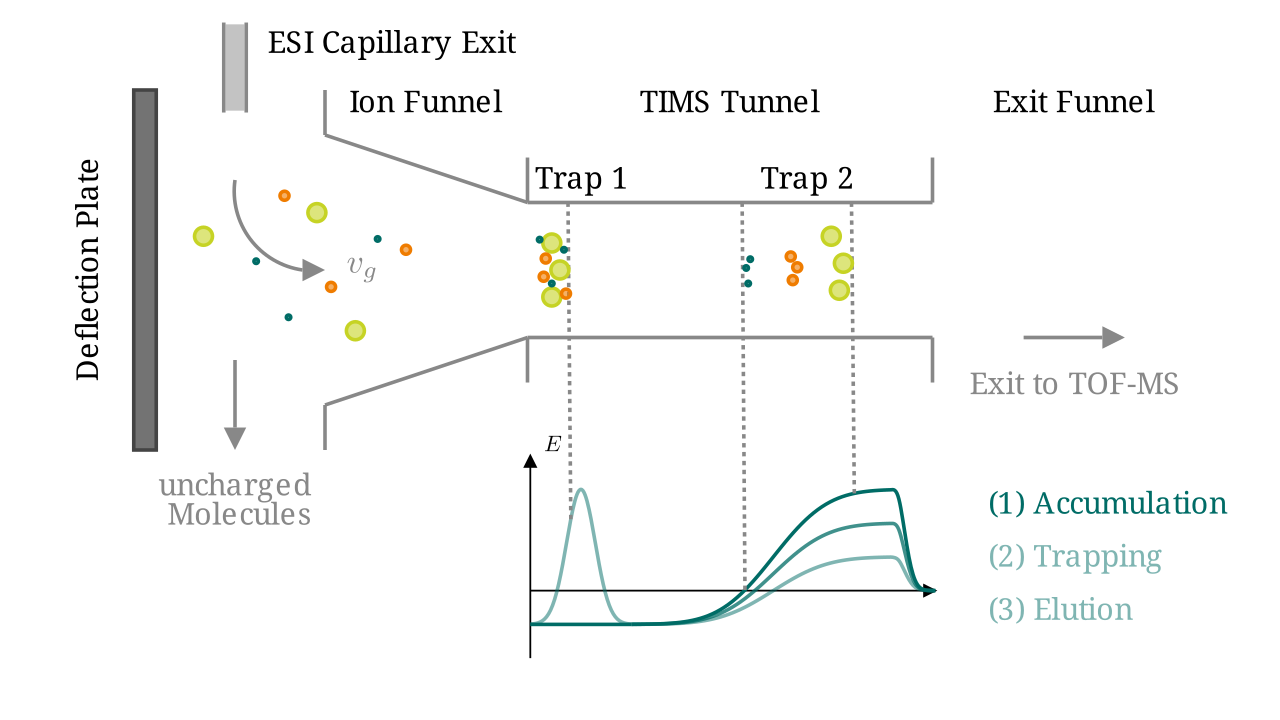

In [110]:
%%capture_video --path "animations/drift_tube.mp4"
%%manim -qm --fps 60 $video_scene


class dt_Scene(Scene):
    def construct(self):
        self.camera.background_color = WHITE

        # headline
        # headline = Title(r"Drift Tube", font_size = 48, color = BLACK).align_on_border(UP + LEFT, buff = 0.5).shift(0.5 * RIGHT)
        # self.add(headline)

        # drift tube
        drift_tube = DriftTube(center = np.array([1, 1, 0]), height = 1.5, width = 4.5)
        self.add(drift_tube)

        deflection_plate = drift_tube.get_deflection_plate()
        self.add(deflection_plate)

        esi_capillary_exit = drift_tube.get_esi_capillary_exit()
        self.add(esi_capillary_exit)


        # draw trap lines
        trap_lines = drift_tube.get_trap_lines()
        self.add(trap_lines)


        # +++ START: draw particles +++

        # # pre tunnel
        # pre_trap_big_list = []
        # for i in range(3):
        #     pre_trap_big_list.append(drift_tube.get_particle_big(pre_trap_big[i]))
        #     self.add(pre_trap_big_list[i])

        # pre_trap_medium_list = []
        # for i in range(3):
        #     pre_trap_medium_list.append(drift_tube.get_particle_medium(pre_trap_medium[i]))
        #     self.add(pre_trap_medium_list[i])

        # pre_trap_small_list = []
        # for i in range(3):
        #     pre_trap_small_list.append(drift_tube.get_particle_small(pre_trap_small[i]))
        #     self.add(pre_trap_small_list[i])


        # # trap 1
        # trap_big_list = []
        # for i in range(3):
        #     trap_big_list.append(drift_tube.get_particle_big(trap_big[i]))
        #     self.add(trap_big_list[i])

        # trap_medium_list = []
        # for i in range(3):
        #     trap_medium_list.append(drift_tube.get_particle_medium(trap_medium[i]))
        #     self.add(trap_medium_list[i])

        # trap_small_list = []
        # for i in range(3):
        #     trap_small_list.append(drift_tube.get_particle_small(trap_small[i]))
        #     self.add(trap_small_list[i])


        # # trap 2
        # accumulation_big_list = []
        # for i in range(3):
        #     accumulation_big_list.append(drift_tube.get_particle_big(accumulation_big[i]))
        #     self.add(accumulation_big_list[i])

        # accumulation_medium_list = []
        # for i in range(3):
        #     accumulation_medium_list.append(drift_tube.get_particle_medium(accumulation_medium[i]))
        #     self.add(accumulation_medium_list[i])

        # accumulation_small_list = []
        # for i in range(3):
        #     accumulation_small_list.append(drift_tube.get_particle_small(accumulation_small[i]))
        #     self.add(accumulation_small_list[i])

        # +++ END: draw particles +++

        # phase descriptors
        phase_descriptor_accumulate = drift_tube.get_phase_descriptor(0)
        phase_descriptor_trap = drift_tube.get_phase_descriptor(1)
        phase_descriptor_elute = drift_tube.get_phase_descriptor(2)
        self.add(phase_descriptor_accumulate)
        
        # efields
        efield_trap = drift_tube.get_efield_trap(strength = 1, hard_funct = 0, stroke_opacity = 0.5)
        efield_trap_off = drift_tube.get_efield_trap(strength = 0, hard_funct = 0, stroke_opacity = 1)
        self.add(efield_trap, efield_trap_off)

        efield_accumulate = drift_tube.get_efield_accumulate(strength = 1, hard_funct = 0)
        efield_accumulate_elute_1 = drift_tube.get_efield_accumulate(strength = 0.75, hard_funct = 0)
        efield_accumulate_elute_2 = drift_tube.get_efield_accumulate(strength = 0.5, hard_funct = 0)
        self.add(efield_accumulate, efield_accumulate_elute_1, efield_accumulate_elute_2)